#Import libraries

In [1]:
%pylab inline
import matplotlib
import seaborn

import random
import pandas as pd
import numpy as np
from yahoo_finance import Share
import matplotlib
import datetime
from datetime import datetime
from sklearn.linear_model import LinearRegression
import matplotlib
import get_symbols

Populating the interactive namespace from numpy and matplotlib


#Create and format dataframe

In [18]:
def get_dailyret(ser):
    return (ser.shift(-1) - ser)/ser


def get_smooth_val(ser, lookback):
    ###does not include today so that residual is relevant for return
    ls = []
    bs = []
    lr = LinearRegression()
    for i in range(len(ser)):
        a = ser[i-lookback:i].tolist()
        #print(a)
        if len(a) == 0:
            ls.append(np.nan)
            bs.append(np.nan)
        else:
            a = lr.fit(np.array(range(lookback)).reshape(lookback,1),np.array(a).reshape((lookback,1)))
            ls.append(float(a.predict(lookback)[0]))
            bs.append(float(a.coef_))
    return ls, bs
    
def get_dfs(strat):
    data = pd.DataFrame(Share(strat).get_historical('2010-05-02', '2015-12-31'))
    print('fetched data')
    data.Date = [datetime.strptime(data.Date.iloc[i], '%Y-%m-%d') for i in data.index]
    data.index = data.Date
    data = data.iloc[::-1]
    data.Close = [float(x) for x in data.Close]#Adj_Close]
    data['smooth'], data['trend'] = get_smooth_val(data.Close, 50)
    data['resid'] = data.Close-data['smooth']
    data['dailyrets'] = get_dailyret(data.Close)
    return data

In [21]:

def get_tickdict(sdf, num=4, gs=False, sample=True):
    numstrats = 0
    tickdict ={}
    if sample:
        sdf = random.sample(sdf,num)
    if gs:
        sdf = ['GS']
    for ticker in sdf:#['GS']:
        print(numstrats)
        print(ticker)
        try:
            tickdict[ticker] = get_dfs(ticker)
        except:
            continue

        numstrats+=1
        
    return  tickdict

In [1]:
sdf = get_symbols.main()
tickdict = get_tickdict(sdf, 4, gs=False)

NameError: name 'get_symbols' is not defined

#calculate results

In [50]:
def sweetspotuser2(ticker, tickdict):
    cs=[]
    eqs=[]
    data = tickdict[ticker]
    data['yesteresid'] = data['resid'].shift(1)
    data['residvar'] = [np.std(data.resid.iloc[i-100:i]) for i in range(len(data))]
    
    data  = tickdict[ticker]#.tail(250)
    
    #c = cs[np.argmax(eqs)]
    data['stratret'] = trade_logic(data, 11)
    eqcurve = np.cumprod(3*data.stratret+1)
    return eqcurve[-2], data['stratret']
            
            
    
def trade_logic(data, c):
    position = 'out'
    thresh = 0
    rets = []
    for i in range(data.shape[0]):
        threshold=data['residvar'].iloc[i]*c
        threshold = 11
        if position == 'out':
            if data['resid'].iloc[i]>threshold:
                if data['resid'].iloc[i]<data['yesteresid'].iloc[i]:
                    position = 'short'
                    thresh = data['yesteresid'].iloc[i]
                    rets.append(-data['dailyrets'].iloc[i])
                    continue
                else:
                    rets.append(0)
                    continue
                    
            if data['resid'].iloc[i]<-threshold:
                if data['resid'].iloc[i]>data['yesteresid'].iloc[i]:
                    position = 'long'
                    thresh = data['yesteresid'].iloc[i]
                    rets.append(data['dailyrets'].iloc[i])
                    continue
                else:
                    rets.append(0)
                    continue
            
            else:
                rets.append(0)
                continue
               
        if position == 'long':
            if data['resid'].iloc[i]>0:
                position = 'out'
                rets.append(0)
                continue
            if data['resid'].iloc[i]<thresh:
                position = 'out'
                rets.append(0)
                continue
            else:
                rets.append(data['dailyrets'].iloc[i])
                continue
        if position == 'short':
            if data['resid'].iloc[i]<0:
                position = 'out'
                rets.append(0)
                continue
            if data['resid'].iloc[i]>thresh:
                position = 'out'
                rets.append(0)
                continue
            else:
                rets.append(-data['dailyrets'].iloc[i])
                continue
                
    return pd.Series(rets, index = data.index)


def main3(tickdict, plot=True):
    def dd(pnl):
        max_accum = np.maximum.accumulate(pnl)
        max_curr_df = np.subtract(max_accum,pnl)
        #max_drawdown = np.amax(max_curr_df)
        return max(max_curr_df)
    
    portf = []
    porteq = pd.Series()
    numstrats = 0
    dds=[]
    for key in tickdict:
        print('')
        print(numstrats)
        
        print('symbol: %s: ' % key)

        #r, e = sweetspotuser2(key, tickdict)
        try:
            r, e = sweetspotuser2(key, tickdict)
        except:
            continue
            
        numstrats+=1
            
            
        portf.append(r)

        if numstrats ==1:
            porteq = e
        else:
            ##special average calc
            porteq =((numstrats-1)* porteq+e)/numstrats
        
        
        ##########PRINT STATEMENTS#######
        portcurve = np.cumprod(3*porteq+1)
        print('portfolio ret: %s' % (portcurve[-2]-1))
        dd1 = dd(np.cumprod(3*e+1))
        dds.append(dd1)
        pvol = np.std(3*porteq)*15.8745
        print('portfolio vol: %s' %pvol)
        psharpe = (portcurve[-2]-1)/pvol
        print('port sharpe: %s' % psharpe)

        
        print('portfolio dd: %s' % dd(portcurve))
        promad = (portcurve[-2]-1)/dd(portcurve)
        print('portf romad: %s' %promad)
        
        iromad = np.mean(portf)-1/np.mean(dds)
        
        matplotlib.pyplot.plot(np.cumprod(3*e+1))
        matplotlib.pyplot.show()
        matplotlib.pyplot.plot(portcurve)
        matplotlib.pyplot.show()



0
symbol: GS: 
portfolio ret: 1.50918622754
portfolio vol: 0.28806687692199323
port sharpe: 5.23901339738
portfolio dd: 1.25040585267
portf romad: 1.20695710462


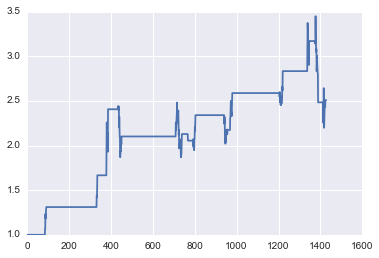

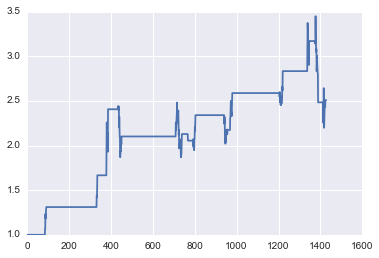

In [51]:
main3(tickdict)

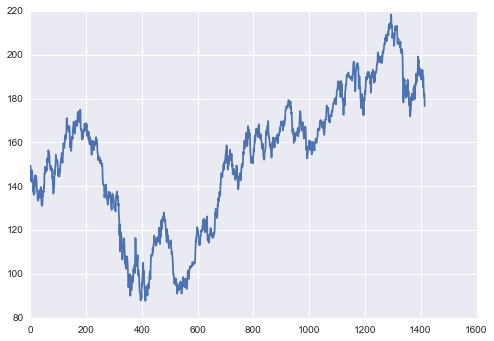

In [27]:
plot(tickdict['GS'].Close)

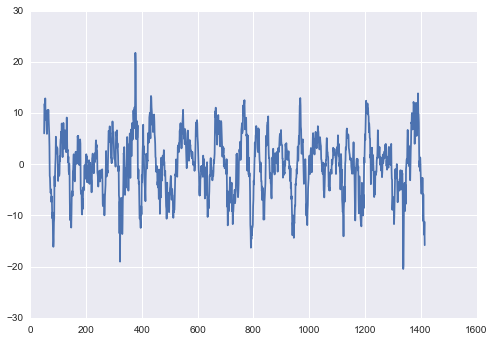

In [29]:
plot(tickdict['GS'].resid)

In [36]:
tickdict['GS']

,Adj_Close,Close,Date,High,Low,Open,Symbol,Volume,smooth,trend,resid,dailyrets,yesteresid,residvar,stratret
Date,,,,,,,,,,,,,,,
2010-05-03,138.774607,149.500000,2010-05-03,150.649994,146.539993,147.839996,GS,28282700,NaN,NaN,NaN,-0.000334,NaN,NaN,0.000000
2010-05-04,138.728191,149.449997,2010-05-04,152.350006,147.830002,149.029999,GS,30313400,NaN,NaN,NaN,-0.008431,NaN,NaN,0.000000
2010-05-05,137.558591,148.190002,2010-05-05,151.220001,147.199997,148.100006,GS,18355200,NaN,NaN,NaN,-0.039611,NaN,NaN,0.000000
2010-05-06,132.10972,142.320007,2010-05-06,148.630005,139.059998,147.479996,GS,22984700,NaN,NaN,NaN,0.004708,NaN,NaN,0.000000
2010-05-07,132.731651,142.990005,2010-05-07,146.550003,141.50,145.380005,GS,21268500,NaN,NaN,NaN,0.005875,NaN,NaN,0.000000
2010-05-10,133.511384,143.830002,2010-05-10,149.899994,141.199997,149.089996,GS,23098200,NaN,NaN,NaN,-0.012932,NaN,NaN,0.000000
2010-05-11,131.784823,141.970001,2010-05-11,145.50,141.550003,142.399994,GS,15497900,NaN,NaN,NaN,0.036839,NaN,NaN,0.000000
2010-05-12,136.63961,147.199997,2010-05-12,147.649994,142.279999,144.240005,GS,15457000,NaN,NaN,NaN,-0.017323,NaN,NaN,0.000000
2010-05-13,134.272549,144.649994,2010-05-13,148.449997,144.419998,148.360001,GS,11517900,NaN,NaN,NaN,-0.009817,NaN,NaN,0.000000
